In [2]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install kagglehub
!pip install xgboost
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 7.0 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.1 MB 7.5 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 6.9 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 6.4 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 6.1 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.2 MB 5.7 MB/s eta 0:00:01
   -------------------------------- ------- 1.8/2.2 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 4.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import kagglehub
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [8]:
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')

Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


In [9]:
# 特徵與標籤分離
X = np.asarray(data.drop(columns=['Class']))
y = np.asarray(data['Class'])

# 資料分割
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE,random_state=RANDOM_SEED, stratify=y
)

# 標準化處理
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=20)  
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [10]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(
    n_estimators=500,             # 增加樹的數量以提高穩定性
    contamination=0.0017,        # 設置為已知的異常比例
    max_samples=128,              # 每棵樹使用的樣本數較小，提高對異常的敏感度
    max_features=0.8,             # 每棵樹使用 80% 的特徵
    random_state=RANDOM_SEED     # 固定隨機種子以便重現
)
isolation_forest.fit(x_train)
anomaly_scores = isolation_forest.decision_function(x_train)
isolation_pred = (anomaly_scores < -0.1).astype(int)

# 合併特徵
anomaly_scores_train = isolation_forest.decision_function(x_train)
anomaly_scores_test = isolation_forest.decision_function(x_test)
isolation_pred_train = (anomaly_scores_train < -0.1).astype(int)
isolation_pred_test = (anomaly_scores_test < -0.1).astype(int)

# 合併異常分數作為特徵
x_train_combined = np.hstack((x_train, anomaly_scores_train.reshape(-1, 1)))
x_test_combined = np.hstack((x_test, anomaly_scores_test.reshape(-1, 1)))


In [15]:

from sklearn.metrics import f1_score, classification_report

# 設置 XGBClassifier
positive_class_weight = sum(y_train == 0) / sum(y_train == 1)

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=19,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.1,
    scale_pos_weight=positive_class_weight,  # 設置權重
    random_state=RANDOM_SEED
)

# 訓練模型
xgb_model.fit(x_train_combined, y_train)

# 預測機率
y_prob = xgb_model.predict_proba(x_test_combined)[:, 1]

# 動態調整閾值
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, (y_prob > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

# 使用最佳閾值
y_pred = (y_prob > best_threshold).astype(int)

# 評估結果
print(f"Best Threshold: {best_threshold}")
print(classification_report(y_test, y_pred))




Best Threshold: 0.21
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.80      0.83       148

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [16]:
def evaluation(y_true, y_pred, model_name="Model"):
   accuracy = accuracy_score(y_true, y_pred)
   precision = precision_score(y_true, y_pred, zero_division=0)
   recall = recall_score(y_true, y_pred)
   f1 = f1_score(y_true, y_pred)

   print(f'\n{model_name} Evaluation:')
   print('===' * 15)
   print('         Accuracy:', accuracy)
   print('  Precision Score:', precision)
   print('     Recall Score:', recall)
   print('         F1 Score:', f1)
   print("\nClassification Report:")
   print(classification_report(y_true, y_pred))

evaluation(y_test, y_pred, model_name="Hybrid")


Hybrid Evaluation:
         Accuracy: 0.9994382219725431
  Precision Score: 0.8676470588235294
     Recall Score: 0.7972972972972973
         F1 Score: 0.8309859154929577

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.80      0.83       148

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



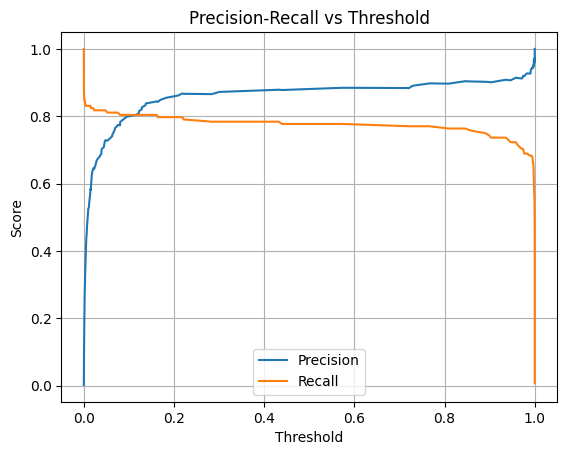

In [17]:

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()
